In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Importo libreria para trabajar con dates 
from datetime import timedelta
# Libreria para estimar regresión
import statsmodels.formula.api as sm
# Libreria para normalizar
from sklearn.preprocessing import StandardScaler

# OBJETIVO: Predecir la probabilidad de que el precio de una acción de Galicia suba en al menos un 5% dentro de un mes

<br> <br/>
### Contexto comercial 
Soy un inversionista que quiere tener una ganancia de al menos un 5% respecto de su inversión inicial, al mes siguiente. Estoy evaluando comprar acciones del Banco Galicia, y quiero saber si existe probabilidad de que la acción valga un 5% más al próximo mes. 
<br> <br/>
### Problema comercial
Para tomar la decisión sobre comprar o no acciones del Banco Galicia es necesario contar con una probabilidad de aumento de al menos un 5% del valor de la misma.
<br> <br/>
### Contexto analítico 
Para poder desarrollar el modelo se cuenta con ña siguiente información:
<br> <br/>
* **Acciones Banco Galicia:** Historial de precios de apertura (Open), cierre (Close), máximo y mínimo precio del día (High y Low respectivamente), precio de cierre ajustado después de los ajustes para todas las distribuciones de splits y dividendos aplicables (Adj Close) y el total de acciones negiciadas durante el día (Volume). Periodo abarcado: 25/01/2017 a 22/09/2023. 
* **Acciones Banco Santander:** Historial de precios de apertura (Open), cierre (Close), máximo y mínimo precio del día (High y Low respectivamente), precio de cierre ajustado después de los ajustes para todas las distribuciones de splits y dividendos aplicables (Adj Close) y el total de acciones negiciadas durante el día (Volume). Periodo abarcado: 25/01/2017 a 22/09/2023. 
<br> <br/>

In [2]:
# Levanto la data descargada 
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/GGAL.csv'
galicia = pd.read_csv(url, sep = ',')

url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/SAN.MC.csv'
santander = pd.read_csv(url, sep = ',')

# Primera exploración

In [3]:
galicia.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-25,33.060001,33.259998,31.760000,32.75,27.493952,640300
1,2017-01-26,32.509998,32.959999,31.780001,31.90,26.780361,197900
2,2017-01-27,31.639999,31.889999,31.059999,31.34,26.310238,299400
3,2017-01-30,30.920000,31.150000,30.660000,30.84,25.890488,284800
4,2017-01-31,30.610001,31.240000,30.610001,31.07,26.083569,446800


In [4]:
santander.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,4.638409,4.707217,4.636524,4.703447,3.601206,20481554.0
1,2017-01-03,4.712873,4.880651,4.709103,4.817499,3.688530,63383417.0
2,2017-01-04,4.838235,4.885364,4.789221,4.839178,3.705129,63903436.0
3,2017-01-05,4.829752,4.891962,4.802417,4.853316,3.715955,52036072.0
4,2017-01-06,4.840120,4.881594,4.811843,4.880651,3.736883,29360034.0


# Paso 1: definir qué estructura necesito 
<br>
Para construir un dataset analizable apuntando al objetivo para el cual estoy estudiando la data, primero necesito definir de manera concreta y objetiva qué quisiera hacer en este dataset. 
<br>
<br>

**Objetivo:** Predicir cuál será la probabilidad de que el precio de la acción al cierre del Banco Galicia exactamente dentro de 30 días sea al menos un 5% superior al momento del análisis. 
<br>

**Variable Target:** Binaria. Indica un 1 si la acción del Banco Galicia supera al menos un 5% del valor dentro de un mes, un 0 en otro caso.  
<br>

**Features:** Información relacionada al historial de precios tanto del Banco Galicia como del Banco Santander. 
<br>
<br>
#### Ejemplo puntual de cómo construir un renglón:
<br>

Si me paro en el 23/08/2023: 
<br>
1- El precio de la acción del Banco Galicia el 23/08/2023 será el punto inicial de observación en mi ventana de performance.
<br>
2- El precio de la acción del Banco Galicia el 22/09/2023 será el punto final de observación en mi ventana de performance.
<br>
3- El target se construirá de la siguiente manera: 
* Si Precio 20230923 >= (Precio 20230823 incrementado en 5%) entonces 1
* Si Precio 20230823 < (Precio 20230823 incrementado en 5%) entonces 0
<br>
4- El historial de precios y volúmenes antes del 23/08/2023 será información disponible para construir features 
<br>
<br>

**Entonces:** Muy importante conocer el concepto de **Punto de Observación**. 
Esto se refiere al momento del tiempo en que me estoy posicionando para construir el dataset de entrenamiento:

<br>

* La variable **Target** se calcula al momento del punto de observación o de manera posterior.
* Los **Features** siempre deben calcularse con anteioridad al punto de observación. **SIEMPRE**.

<br>

In [5]:
# Empiezo a construir mi estructura principal "df"
df = pd.DataFrame(galicia[['Date','Close']])
df.rename(columns={'Date': 'Date_Target','Close': 'Close_Target'}, inplace=True)
df.head()

,Date_Target,Close_Target
0,2017-01-25,32.75
1,2017-01-26,31.90
2,2017-01-27,31.34
3,2017-01-30,30.84
4,2017-01-31,31.07


In [6]:
# Transformo en tipo de dato "datetime" y calculo la fecha de hace 30 dias
df['Date_Target'] = pd.to_datetime(df['Date_Target'])
df['Date_Obs'] = df['Date_Target'] - pd.DateOffset(days=30)
df.head()

,Date_Target,Close_Target,Date_Obs
0,2017-01-25,32.75,2016-12-26
1,2017-01-26,31.90,2016-12-27
2,2017-01-27,31.34,2016-12-28
3,2017-01-30,30.84,2016-12-31
4,2017-01-31,31.07,2017-01-01


In [7]:
# Primero transformo las fechas de mi dataset en tipo dates: 
galicia['Date'] = pd.to_datetime(galicia['Date'])
santander['Date'] = pd.to_datetime(santander['Date'])

In [8]:
# Para terminar el target, me traigo el precio de cierre de hace 30 / 35 días: 
# Definir el margen de tiempo de +/- 5 días
margen = timedelta(days = 5)

# Realizar la unión basada en el margen de tiempo
df = pd.merge_asof(df, galicia[['Date','Close']], 
                          left_on = 'Date_Obs',  
                          right_on = 'Date', 
                          direction = 'backward', 
                          tolerance = margen)
df.drop('Date', axis=1, inplace=True)

In [9]:
df.head()

,Date_Target,Close_Target,Date_Obs,Close
0,2017-01-25,32.75,2016-12-26,NaN
1,2017-01-26,31.90,2016-12-27,NaN
2,2017-01-27,31.34,2016-12-28,NaN
3,2017-01-30,30.84,2016-12-31,NaN
4,2017-01-31,31.07,2017-01-01,NaN


In [ ]:
# Renonmbro features y printeo
df.rename(columns={'Close': 'Close_Obs'}, inplace=True)

df.head(100)

## Evaluemos valores vacíos 
<br>
Tenemos que preguntarnos, por qué hay valores vacíos? Vamos a inspeccionar: 

In [11]:
# Cuento vacíos 
df['Close_Obs'].isnull().value_counts()


Close_Obs
False    1656
True       21
Name: count, dtype: int64

In [12]:
# Quienes son? 
df.loc[df['Close_Obs'].isnull() == True,]

,Date_Target,Close_Target,Date_Obs,Close_Obs
0,2017-01-25,32.750000,2016-12-26,NaN
1,2017-01-26,31.900000,2016-12-27,NaN
2,2017-01-27,31.340000,2016-12-28,NaN
3,2017-01-30,30.840000,2016-12-31,NaN
4,2017-01-31,31.070000,2017-01-01,NaN
5,2017-02-01,31.350000,2017-01-02,NaN
6,2017-02-02,32.020000,2017-01-03,NaN
7,2017-02-03,32.360001,2017-01-04,NaN
8,2017-02-06,32.520000,2017-01-07,NaN
9,2017-02-07,33.220001,2017-01-08,NaN


Los valores vacíos que vemos son porque el target es lo más antiguo que tenía el dataset, cuando busco la data de hace un mes no existe en el dataset!
<br>

Lo que voy a hacer es dejarlos fuera del análisis, ya que no puedo calcular features para esas fechas. 

In [13]:
# Elimino registros con valores vacíos 
df = df.dropna()
df.shape

(1656, 4)

In [14]:
df.head()

,Date_Target,Close_Target,Date_Obs,Close_Obs
21,2017-02-24,32.570000,2017-01-25,32.75
22,2017-02-27,32.299999,2017-01-28,31.34
23,2017-02-28,31.799999,2017-01-29,31.34
24,2017-03-01,32.910000,2017-01-30,30.84
25,2017-03-02,32.570000,2017-01-31,31.07


In [15]:
# Termino de generar mi variable target 
df['Target'] = np.where(df['Close_Target'] >= (df['Close_Obs'] * 1.05),1,0) 

In [16]:
df.head()

,Date_Target,Close_Target,Date_Obs,Close_Obs,Target
21,2017-02-24,32.570000,2017-01-25,32.75,0
22,2017-02-27,32.299999,2017-01-28,31.34,0
23,2017-02-28,31.799999,2017-01-29,31.34,0
24,2017-03-01,32.910000,2017-01-30,30.84,1
25,2017-03-02,32.570000,2017-01-31,31.07,0


# Paso 2: Creación de Features
Acá es donde tenemos que darle rienda suelta a nuestra creatividad. ¿Qué se nos ocurre que sería un buen indicador sobre la probabilidad de que el precio de la acción aumente? 

Arranquemos estudiando las variaciones de la misma acción. 

## Feature 1: Variación en el mes anterior
* Nombre: Var_1m
* Construcción: Cociente entre el precio de cierre de la acción al momento del análisis y el precio un mes antes, -1 (para capturar variación)

In [17]:
import pandas  as pd

In [18]:
# Empiezo con la construcción!

# Primero me genero una columna que indique la fecha 30 días antes del punto de observación 
df['Date_30dAntes'] = df['Date_Obs'] - pd.DateOffset(days=30)

# Definir el margen de tiempo de +/- 5 días
margen = timedelta(days = 5)

# Realizar la unión basada en el margen de tiempo
df = pd.merge_asof(df, galicia[['Date','Close']], 
                          left_on = 'Date_30dAntes',  
                          right_on = 'Date', 
                          direction = 'backward', 
                          tolerance = margen)
df.drop('Date', axis=1, inplace=True)

# Renonmbro 
df.rename(columns={'Close': 'Close_30dAntes'}, inplace=True)

# Luego construyo efectivamente la variable que quería construir 
df['Var_1m'] = (df['Close_Obs'] / df['Close_30dAntes']) -1

In [19]:
df.head()
# Ahora tengo vacíos porque no tenían historia, los sigo eliminado

,Date_Target,Close_Target,Date_Obs,Close_Obs,Target,Date_30dAntes,Close_30dAntes,Var_1m
0,2017-02-24,32.570000,2017-01-25,32.75,0,2016-12-26,NaN,NaN
1,2017-02-27,32.299999,2017-01-28,31.34,0,2016-12-29,NaN,NaN
2,2017-02-28,31.799999,2017-01-29,31.34,0,2016-12-30,NaN,NaN
3,2017-03-01,32.910000,2017-01-30,30.84,1,2016-12-31,NaN,NaN
4,2017-03-02,32.570000,2017-01-31,31.07,0,2017-01-01,NaN,NaN


In [20]:
df = df.dropna()
df.shape

(1635, 8)

In [21]:
df.head()

,Date_Target,Close_Target,Date_Obs,Close_Obs,Target,Date_30dAntes,Close_30dAntes,Var_1m
21,2017-03-27,38.619999,2017-02-25,32.570000,1,2017-01-26,31.90,0.021003
22,2017-03-28,38.369999,2017-02-26,32.570000,1,2017-01-27,31.34,0.039247
23,2017-03-29,38.439999,2017-02-27,32.299999,1,2017-01-28,31.34,0.030632
24,2017-03-30,38.470001,2017-02-28,31.799999,1,2017-01-29,31.34,0.014678
25,2017-03-31,37.860001,2017-03-01,32.910000,1,2017-01-30,30.84,0.067121


In [22]:
df['Var_1m'].describe()

count    1635.000000
mean        0.010090
std         0.191023
min        -0.726728
25%        -0.098135
50%         0.011210
75%         0.120829
max         0.791667
Name: Var_1m, dtype: float64

## Feature 2: Variación hace 15 días
* Nombre: Var_15d
* Construcción: Cociente entre el precio de cierre de la acción al momento del análisis y el precio quince días antes, -1 (para capturar variación)

In [23]:

# Primero me genero una columna que indique la fecha 30 días antes del punto de observación 
df['Date_15dAntes'] = df['Date_Obs'] - pd.DateOffset(days=15)

# Definir el margen de tiempo de +/- 5 días
margen = timedelta(days = 5)

# Realizar la unión basada en el margen de tiempo
df = pd.merge_asof(df, galicia[['Date','Close']], 
                          left_on = 'Date_15dAntes',  
                          right_on = 'Date', 
                          direction = 'backward', 
                          tolerance = margen)
df.drop('Date', axis=1, inplace=True)

# Renonmbro features
df.rename(columns={'Close': 'Close_15dAntes'}, inplace=True)

# Luego construyo efectivamente la variable que quería construir 
df['Var_15d'] = (df['Close_Obs'] / df['Close_15dAntes']) -1

In [24]:
df.head()

,Date_Target,Close_Target,Date_Obs,Close_Obs,Target,Date_30dAntes,Close_30dAntes,Var_1m,Date_15dAntes,Close_15dAntes,Var_15d
0,2017-03-27,38.619999,2017-02-25,32.570000,1,2017-01-26,31.90,0.021003,2017-02-10,35.669998,-0.086908
1,2017-03-28,38.369999,2017-02-26,32.570000,1,2017-01-27,31.34,0.039247,2017-02-11,35.669998,-0.086908
2,2017-03-29,38.439999,2017-02-27,32.299999,1,2017-01-28,31.34,0.030632,2017-02-12,35.669998,-0.094477
3,2017-03-30,38.470001,2017-02-28,31.799999,1,2017-01-29,31.34,0.014678,2017-02-13,34.490002,-0.077994
4,2017-03-31,37.860001,2017-03-01,32.910000,1,2017-01-30,30.84,0.067121,2017-02-14,34.700001,-0.051585


In [25]:
df['Var_15d'].describe()

count    1635.000000
mean        0.003861
std         0.128718
min        -0.634530
25%        -0.063508
50%         0.007159
75%         0.074345
max         0.472175
Name: Var_15d, dtype: float64

## Feature 3: Variación hace un mes, pero de acciones del Santander
* Nombre: Var_1m_Santander
* Construcción: Cociente entre el precio de cierre de la acción del Banco Santander al momento del análisis y el precio un mes antes, -1 (para capturar variación)

In [26]:
# Primero me traigo el precio de la acción de Santander al momento del análisis
df = pd.merge_asof(df, santander[['Date','Close']], 
                          left_on = 'Date_Obs',  
                          right_on = 'Date', 
                          direction = 'backward', 
                          tolerance = margen)
df.drop('Date', axis=1, inplace=True)
df.rename(columns={'Close': 'Close_Obs_Santander'}, inplace=True)

# Definir el margen de tiempo de +/- 5 días
margen = timedelta(days = 5)

# Realizar la unión basada en el margen de tiempo
df = pd.merge_asof(df, santander[['Date','Close']], 
                          left_on = 'Date_30dAntes',  
                          right_on = 'Date', 
                          direction = 'backward', 
                          tolerance = margen)
df.drop('Date', axis=1, inplace=True)
# Renonmbro features
df.rename(columns={'Close': 'Close_30dAntes_Santander'}, inplace=True)

# Luego construyo efectivamente la variable que quería construir 
df['Var_1m_Santander'] = (df['Close_Obs_Santander'] / df['Close_30dAntes_Santander']) -1

## Feature 4: Variación hace quince días, pero de acciones del Santander
* Nombre: Var_15d_Santander
* Construcción: Cociente entre el precio de cierre de la acción del Banco Santander al momento del análisis y el precio hace 15 días, -1 (para capturar variación)

In [27]:
# Definir el margen de tiempo de +/- 5 días
margen = timedelta(days = 5)

# Realizar la unión basada en el margen de tiempo
df = pd.merge_asof(df, santander[['Date','Close']], 
                          left_on = 'Date_15dAntes',  
                          right_on = 'Date', 
                          direction = 'backward', 
                          tolerance = margen)
df.drop('Date', axis=1, inplace=True)
# Renonmbro features
df.rename(columns={'Close': 'Close_15dAntes_Santander'}, inplace=True)

# Luego construyo efectivamente la variable que quería construir 
df['Var_15d_Santander'] = (df['Close_Obs_Santander'] / df['Close_15dAntes_Santander']) -1

In [28]:
df.head()

,Date_Target,Close_Target,Date_Obs,Close_Obs,Target,Date_30dAntes,Close_30dAntes,Var_1m,Date_15dAntes,Close_15dAntes,Var_15d,Close_Obs_Santander,Close_30dAntes_Santander,Var_1m_Santander,Close_15dAntes_Santander,Var_15d_Santander
0,2017-03-27,38.619999,2017-02-25,32.570000,1,2017-01-26,31.90,0.021003,2017-02-10,35.669998,-0.086908,4.759059,5.054085,-0.058374,4.751518,0.001587
1,2017-03-28,38.369999,2017-02-26,32.570000,1,2017-01-27,31.34,0.039247,2017-02-11,35.669998,-0.086908,4.759059,5.049372,-0.057495,4.751518,0.001587
2,2017-03-29,38.439999,2017-02-27,32.299999,1,2017-01-28,31.34,0.030632,2017-02-12,35.669998,-0.094477,4.766600,5.049372,-0.056001,4.751518,0.003174
3,2017-03-30,38.470001,2017-02-28,31.799999,1,2017-01-29,31.34,0.014678,2017-02-13,34.490002,-0.077994,4.858029,5.049372,-0.037894,4.836350,0.004483
4,2017-03-31,37.860001,2017-03-01,32.910000,1,2017-01-30,30.84,0.067121,2017-02-14,34.700001,-0.051585,5.013554,4.904215,0.022295,4.874053,0.028621


# Paso 3: EDA
Arranquemos analizando la distribución general de la variable target. 
<br>
Luego pasamos al análisis de Features, que hasta el momento son las siguientes: 
* Var_1m
* Var_15d
* Var_1m_Santander
* Var_15d_Santander
 

## Variable target
Como ya describimos inicialmente, nuestra variable target indica si la acción del Banco Galicia aumentó en al menos un 5% de un mes al otro. Identifiquemos en qué proporción de los días estudiados ocurrió eso. 

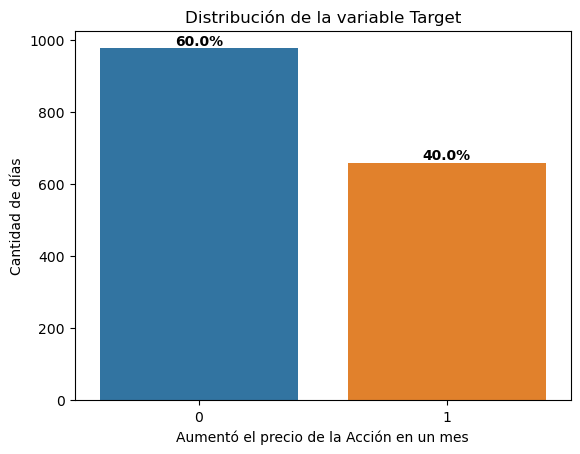

In [29]:
# Analicemos la distribución de nuestra variable target
cantidad = len(df['Target'])

sns.countplot(data = df,
              x = "Target")
plt.xlabel('Aumentó el precio de la Acción en un mes')
plt.ylabel('Cantidad de días')
plt.title('Distribución de la variable Target')
ax = plt.gca()
for p in ax.patches:
    x_text = p.get_x() + p.get_width() / 2.0  # Calcula la posición x del texto
    y_text = p.get_height()  # Toma la altura de la columna
    ax.text(x_text, y_text, f'{str(round(int(y_text)/cantidad,2) * 100)}%', # Indica posición x e y, y texto a mostrar 
            ha = 'center', # Alineación horizontal 
            va = 'bottom',  # Alineación vertical
            fontsize = 10, color = 'black', fontweight = 'bold')
plt.show()


Se puede observar que un 40% de los días analizados tuvieron un incremento superior al 5% un mes después. 

## Análisis diario
Veamos ahora si se observa alguna especie de tendencia en el tiempo. 

Text(0.5, 1.0, 'Precio de Cierre por día, identificado si subió o no')

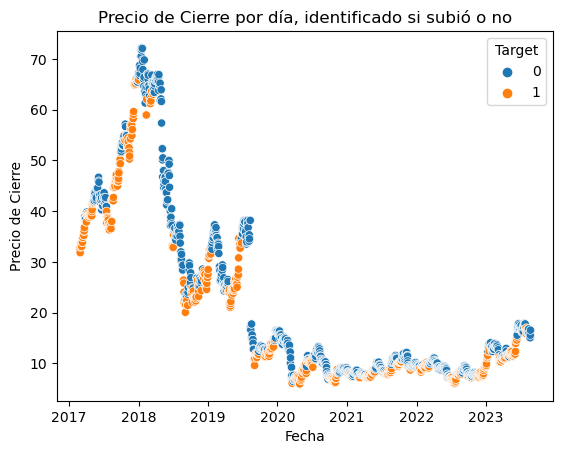

In [30]:
sns.scatterplot(data = df,
                x = 'Date_Obs',
                y = 'Close_Obs',
                hue = 'Target')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Precio de Cierre por día, identificado si subió o no')

Text(0.5, 1.0, 'Tasa de aumento por año')

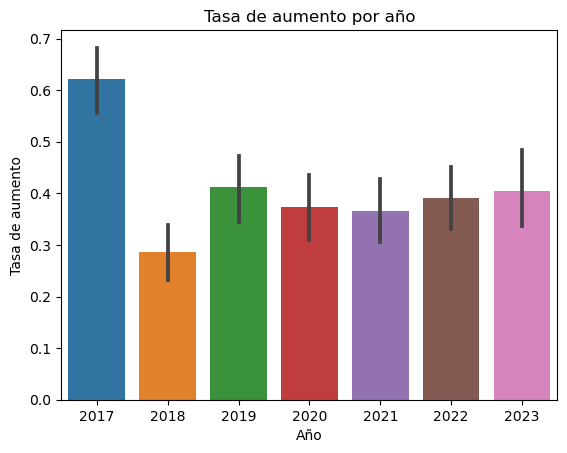

In [31]:
# Y por año? 
df['Periodo_Obs'] = df['Date_Obs'].dt.year
sns.barplot(data = df,
                x = 'Periodo_Obs',
                y = 'Target')
plt.xlabel('Año')
plt.ylabel('Tasa de aumento')
plt.title('Tasa de aumento por año')

## Primera conclusión: 
Los ratios observados entre 2017 y 2018 difieren muchísimo al resto de los años (puede ser por alguna crisis ocurrida en dichos años, o algo por el estilo). 
<br>
Por ello, se procede a eliminar de la muestra de desarrollo a esos dos años para avanzar con los estudios. 

In [32]:
df = df.loc[df['Periodo_Obs'] > 2018,]
promedio = df['Target'].mean()
df.shape

(1170, 17)

### Entonces, el target queda construido de la siguiente manera: 
1. Datos a partir de 2019 en adelante
2. Tasa de éxito del **39%**

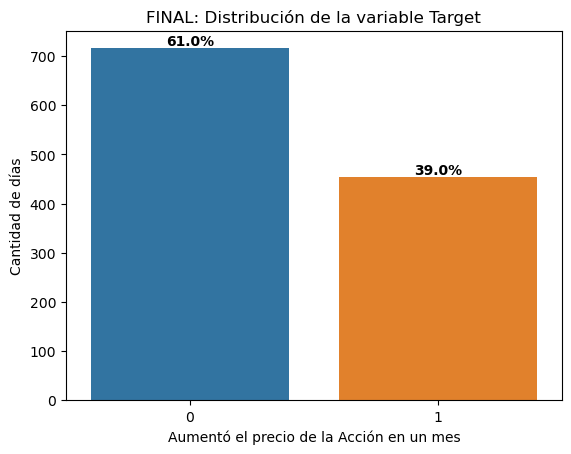

In [33]:
# Analicemos la distribución de nuestra variable target
cantidad = len(df['Target'])

sns.countplot(data = df,
              x = "Target")
plt.xlabel('Aumentó el precio de la Acción en un mes')
plt.ylabel('Cantidad de días')
plt.title('FINAL: Distribución de la variable Target')
ax = plt.gca()
for p in ax.patches:
    x_text = p.get_x() + p.get_width() / 2.0  # Calcula la posición x del texto
    y_text = p.get_height()  # Toma la altura de la columna
    ax.text(x_text, y_text, f'{str(round(int(y_text)/cantidad,2) * 100)}%', # Indica posición x e y, y texto a mostrar 
            ha = 'center', # Alineación horizontal 
            va = 'bottom',  # Alineación vertical
            fontsize = 10, color = 'black', fontweight = 'bold')
plt.show()

## Information Value: ¿Qué es? 
Es una métrica que nos ayuda a responder la siguiente pregunta: 
<br>
**¿Cuánta información útil aporta esta variable para predecir el resultado deseado?**
<br>
<br>
**Pasos para el cálculo:**
1. Se debe genrar una categorización de la variable (si es numérica, "binnearla" de alguna manera, estableciendo rangos para el análisis)
2. Se genera una tabla agrupada de la variable categorizada vs la variable target binaria. El objetivo es saber para cada categoría, qué cantidad de 1 y qué cantidad de 0 se observaron, para calcular "Tasa_Exito" (porcentajes de 1) y "Tasa_No_Exito" (porcentajes de 0). 
3. Se calcula el logaritmo natural del cociente entre la tasa de exito y no exito para cada categoría. 
4. Se calcula el porcentaje de éxitos que representa cada categoría. Lo mismo para los no éxitos. Se restan ambas columnas.  
5. Se multiplican 3 y 4
6. Se suma 5

## Manos a la obra!
Para homogenenizar el cálculo, dividamos nuestros 4 features en los siguientes rangos: 
* menor a -0.1
* entre -0.1 y -0-05
* entre -0.05 y 0.05
* entre 0.5 y 0.1
* mayor a 0.1


In [34]:
# Defino cortes
bin_edges = [-9999, -0.1, -0.05, 0.05, 0.1, 99999]
bin_labels = ['< -0.1','-0.1 a -0.05','-0.05 a 0.05', '0.05 a 0.1', '> 0.1']

# Las categorizo
df['Var_1m_Bin'] = pd.cut(df['Var_1m'], 
                                  bins = bin_edges, 
                                  labels = bin_labels, 
                                  include_lowest = True)

df['Var_15d_Bin'] = pd.cut(df['Var_15d'], 
                                  bins = bin_edges, 
                                  labels = bin_labels, 
                                  include_lowest = True)

df['Var_1m_Santander_Bin'] = pd.cut(df['Var_1m_Santander'], 
                                  bins = bin_edges, 
                                  labels = bin_labels, 
                                  include_lowest = True)


df['Var_15d_Santander_Bin'] = pd.cut(df['Var_15d_Santander'], 
                                  bins = bin_edges, 
                                  labels = bin_labels, 
                                  include_lowest = True)

In [35]:
df.head()

,Date_Target,Close_Target,Date_Obs,Close_Obs,Target,Date_30dAntes,Close_30dAntes,Var_1m,Date_15dAntes,Close_15dAntes,...,Close_Obs_Santander,Close_30dAntes_Santander,Var_1m_Santander,Close_15dAntes_Santander,Var_15d_Santander,Periodo_Obs,Var_1m_Bin,Var_15d_Bin,Var_1m_Santander_Bin,Var_15d_Santander_Bin
465,2019-01-31,36.509998,2019-01-01,27.570000,1,2018-12-02,27.559999,0.000363,2018-12-17,25.420000,...,3.807459,4.010626,-0.050657,3.859209,-0.013409,2019,-0.05 a 0.05,0.05 a 0.1,-0.1 a -0.05,-0.05 a 0.05
466,2019-02-01,36.180000,2019-01-02,28.480000,1,2018-12-03,28.559999,-0.002801,2018-12-18,26.160000,...,3.811771,4.094001,-0.068937,3.823750,-0.003133,2019,-0.05 a 0.05,0.05 a 0.1,-0.1 a -0.05,-0.05 a 0.05
467,2019-02-04,37.060001,2019-01-05,30.700001,1,2018-12-06,27.969999,0.097605,2018-12-21,24.969999,...,3.986188,3.814167,0.045101,3.766730,0.058262,2019,0.05 a 0.1,> 0.1,-0.05 a 0.05,0.05 a 0.1
468,2019-02-05,37.299999,2019-01-06,30.700001,1,2018-12-07,27.740000,0.106705,2018-12-22,24.969999,...,3.986188,3.813209,0.045363,3.766730,0.058262,2019,> 0.1,> 0.1,-0.05 a 0.05,0.05 a 0.1
469,2019-02-06,35.490002,2019-01-07,31.240000,1,2018-12-08,27.740000,0.126172,2018-12-23,24.969999,...,4.008709,3.813209,0.051269,3.766730,0.064241,2019,> 0.1,> 0.1,0.05 a 0.1,0.05 a 0.1


In [36]:
# Genero un dataframe que voy a ir completando con cada IV
IV_df = pd.DataFrame(columns=['Variable', 'IV'])
IV_df.head()

,Variable,IV


In [37]:
# Information value para Var_1m_Bin
tabla_IV = df.groupby('Var_1m_Bin').agg(      
    Cant = ('Target', 'count'),
    Cant_Exito = ('Target', 'sum'),    
    Tasa_Exito = ('Target', 'mean')
).reset_index()
tabla_IV['Tasa_No_Exito'] = 1 - tabla_IV['Tasa_Exito']
tabla_IV['Cant_No_Exito'] = tabla_IV['Cant'] - tabla_IV['Cant_Exito']
tabla_IV['LN'] = np.log(tabla_IV['Tasa_Exito'] / tabla_IV['Tasa_No_Exito'])
tabla_IV['Pct_Exitos'] = tabla_IV['Cant_Exito'] / sum(tabla_IV['Cant_Exito'])
tabla_IV['Pct_NoExitos'] = tabla_IV['Cant_No_Exito'] / sum(tabla_IV['Cant_No_Exito'])
tabla_IV['Resta'] = tabla_IV['Pct_Exitos'] - tabla_IV['Pct_NoExitos']
tabla_IV['IV'] = tabla_IV['Resta'] * tabla_IV['LN'] 
tabla_IV

,Var_1m_Bin,Cant,Cant_Exito,Tasa_Exito,Tasa_No_Exito,Cant_No_Exito,LN,Pct_Exitos,Pct_NoExitos,Resta,IV
0,< -0.1,306,118,0.385621,0.614379,188,-0.465757,0.259912,0.262570,-0.002658,0.001238
1,-0.1 a -0.05,110,57,0.518182,0.481818,53,0.072759,0.125551,0.074022,0.051528,0.003749
2,-0.05 a 0.05,285,107,0.375439,0.624561,178,-0.508955,0.235683,0.248603,-0.012921,0.006576
3,0.05 a 0.1,120,37,0.308333,0.691667,83,-0.807923,0.081498,0.115922,-0.034424,0.027812
4,> 0.1,349,135,0.386819,0.613181,214,-0.460701,0.297357,0.298883,-0.001526,0.000703


In [38]:
# Relleno mi tabla de referencias 
nuevo_dato = {'Variable': 'Var_1m_Bin', 'IV': sum(tabla_IV['IV'])}
IV_df = IV_df.append(nuevo_dato, ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
IV_df.head()

In [ ]:
# Information value para Var_15d_Bin
tabla_IV = df.groupby('Var_15d_Bin').agg(      
    Cant = ('Target', 'count'),
    Cant_Exito = ('Target', 'sum'),    
    Tasa_Exito = ('Target', 'mean')
).reset_index()
tabla_IV['Tasa_No_Exito'] = 1 - tabla_IV['Tasa_Exito']
tabla_IV['Cant_No_Exito'] = tabla_IV['Cant'] - tabla_IV['Cant_Exito']
tabla_IV['LN'] = np.log(tabla_IV['Tasa_Exito'] / tabla_IV['Tasa_No_Exito'])
tabla_IV['Pct_Exitos'] = tabla_IV['Cant_Exito'] / sum(tabla_IV['Cant_Exito'])
tabla_IV['Pct_NoExitos'] = tabla_IV['Cant_No_Exito'] / sum(tabla_IV['Cant_No_Exito'])
tabla_IV['Resta'] = tabla_IV['Pct_Exitos'] - tabla_IV['Pct_NoExitos']
tabla_IV['IV'] = tabla_IV['Resta'] * tabla_IV['LN'] 
tabla_IV

In [ ]:
# Relleno mi tabla de referencias 
nuevo_dato = {'Variable': 'Var_15d_Bin', 'IV': sum(tabla_IV['IV'])}
IV_df = IV_df.append(nuevo_dato, ignore_index=True)

In [ ]:
# Information value para Var_1m_Santander_Bin
tabla_IV = df.groupby('Var_1m_Santander_Bin').agg(      
    Cant = ('Target', 'count'),
    Cant_Exito = ('Target', 'sum'), 
    Tasa_Exito = ('Target', 'mean')
).reset_index()
tabla_IV['Tasa_No_Exito'] = 1 - tabla_IV['Tasa_Exito']
tabla_IV['Cant_No_Exito'] = tabla_IV['Cant'] - tabla_IV['Cant_Exito']
tabla_IV['LN'] = np.log(tabla_IV['Tasa_Exito'] / tabla_IV['Tasa_No_Exito'])
tabla_IV['Pct_Exitos'] = tabla_IV['Cant_Exito'] / sum(tabla_IV['Cant_Exito'])
tabla_IV['Pct_NoExitos'] = tabla_IV['Cant_No_Exito'] / sum(tabla_IV['Cant_No_Exito'])
tabla_IV['Resta'] = tabla_IV['Pct_Exitos'] - tabla_IV['Pct_NoExitos']
tabla_IV['IV'] = tabla_IV['Resta'] * tabla_IV['LN'] 
tabla_IV

In [ ]:
# Relleno mi tabla de referencias 
nuevo_dato = {'Variable': 'Var_1m_Santander_Bin', 'IV': sum(tabla_IV['IV'])}
IV_df = IV_df.append(nuevo_dato, ignore_index=True)

In [ ]:
# Information value para Var_15d_Santander_Bin
tabla_IV = df.groupby('Var_15d_Santander_Bin').agg(      
    Cant = ('Target', 'count'),
    Cant_Exito = ('Target', 'sum'), 
    Tasa_Exito = ('Target', 'mean')
).reset_index()
tabla_IV['Tasa_No_Exito'] = 1 - tabla_IV['Tasa_Exito']
tabla_IV['Cant_No_Exito'] = tabla_IV['Cant'] - tabla_IV['Cant_Exito']
tabla_IV['LN'] = np.log(tabla_IV['Tasa_Exito'] / tabla_IV['Tasa_No_Exito'])
tabla_IV['Pct_Exitos'] = tabla_IV['Cant_Exito'] / sum(tabla_IV['Cant_Exito'])
tabla_IV['Pct_NoExitos'] = tabla_IV['Cant_No_Exito'] / sum(tabla_IV['Cant_No_Exito'])
tabla_IV['Resta'] = tabla_IV['Pct_Exitos'] - tabla_IV['Pct_NoExitos']
tabla_IV['IV'] = tabla_IV['Resta'] * tabla_IV['LN'] 
tabla_IV

In [ ]:
# Relleno mi tabla de referencias 
nuevo_dato = {'Variable': 'Var_15d_Santander_Bin', 'IV': sum(tabla_IV['IV'])}
IV_df = IV_df.append(nuevo_dato, ignore_index=True)

In [ ]:
IV_df.head()

In [ ]:
# Grafico el information value de cada variable
IV_df = IV_df.sort_values(by = 'IV', ascending = False)
plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.barh(IV_df['Variable'], 
         IV_df['IV'],
         color = '#A989D6')
plt.xlabel('Information Value')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la característica más relevante en la parte superior
plt.show()

# Var_15d: Univariado
Veamos cómo se encuentra distribuida la variable, y qué patrones interesantes podemos detectar. 

In [ ]:
df['Var_15d'].describe()

In [ ]:
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'Var_15d',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
             color = '#E7B602')
plt.title('Distribución de Var_15d')

## Primeros análisis: 
Es una variable bastante simétrica, muy concentrada en valores cercanos a cero, por lo que la mayor parte de las veces las variaciones en los precios de los últimos 15 días es cercana a 0. 

# Var_15d: Bivariado
Veamos cómo se encuentra distribuida la variable dependiendo del target. ¿Hay diferencias en las variaciones observadas 15 días antes del momento del análisis? 

In [ ]:
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'Var_15d',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
             hue = 'Target')
plt.title('Distribución de Var_15d')

In [ ]:
# Boxplot
plt.figure()
sns.boxplot(data = df,
            x = 'Target',
            y = 'Var_15d', 
            showfliers = False)

In [ ]:
# Tasas de éxito 
sns.barplot(data = df,
                x = 'Var_15d_Bin',
                y = 'Target')
plt.xlabel('Var_15d_Bin')
plt.ylabel('Tasa de aumento')

## Entonces: 
Si bien se ve un ligero cambio en la distribución de la variable entre la distribución de la variable según si cumple o no con el target, la mayor diferenciación de tasas se ve cuando la variación en los últimos 15 días due superior al 10%. 
<br>
Es decir, de los días en que se detectó una variación mayor al 10% entre el precio de hace 15 días y ese mismo día, casi un 50% presentó un aumento de al menos un 5% al mes siguiente, lo que representa 11 puntos más que el promedio. 

# Var_1m: Univariado
Veamos cómo se encuentra distribuida la variable, y qué patrones interesantes podemos detectar. 

In [ ]:
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'Var_1m',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
             color = '#E7B602')
plt.title('Distribución de Var_1m')

## Primeros análisis: 
Es una variable bastante simétrica, muy concentrada en valores cercanos a cero, por lo que la mayor parte de las veces las variaciones en los precios del último mes es cercana a 0. 

# Var_1m: Bivariado
Veamos cómo se encuentra distribuida la variable dependiendo del target. ¿Hay diferencias en las variaciones observadas un mes antes del momento del análisis? 

In [ ]:
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'Var_1m',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability',
             hue = 'Target')
plt.title('Distribución de Var_1m')

In [ ]:
# Boxplot
plt.figure()
sns.boxplot(data = df,
            x = 'Target',
            y = 'Var_1m', 
            showfliers = False)

In [ ]:
# Tasas de éxito 
sns.barplot(data = df,
                x = 'Var_1m_Bin',
                y = 'Target')
plt.xlabel('Var_1m_Bin')
plt.ylabel('Tasa de aumento')

## Entonces: 
Aquí ocurre algo extraño. La mayor tasa de éxito se observa en las variaciones entre -0.1 y -0.05. ¿Por qué pudo suceder?  
<br>
Es decir, de los días en que se detectó una variación entre -5% y -10% entre el mes de análisis y el mes anterior, fueron los que mayor probabilidad de aumentar al menos un 5% presentaron. 

## Estudiando a las dos variables en conjunto 
Veamos cómo se comportan de manera conjunta estas dos variables. 

In [ ]:
agrupacion = df.groupby(['Var_1m_Bin','Var_15d_Bin']).agg(      
    Tasa_Exito = ('Target', 'mean'),
    Cantidad = ('Target', 'count')).reset_index()

In [ ]:
agrupacion.loc[agrupacion['Cantidad'] > 50,].sort_values(by = 'Tasa_Exito', ascending = False)

# Un análisis diferente
Hay alguna tendencia según el momento del año en el que nos encontramos? 
Generemos variables identificadoras para ver un mapa de calor al respecto. 

In [ ]:
df['Mes'] = df['Date_Obs'].dt.month
df['Dia'] = df['Date_Obs'].dt.day

# Trimestre
bin_edges = [0, 3, 6, 9, 12]
bin_labels = ['Trimestre 1','Trimestre 2','Trimestre 3', 'Trimestre 4']
df['Trimestre'] = pd.cut(df['Mes'], 
                                  bins = bin_edges, 
                                  labels = bin_labels, 
                                  include_lowest = True)
# Dias de a 5 en 5
bin_edges = [0, 5, 10, 15, 20, 25, 9999]
bin_labels = ['1 - 5','6 - 10','11 - 15', '16 - 20', '21 - 25', '26 - 31']
df['Dia_5'] = pd.cut(df['Dia'], 
                                  bins = bin_edges, 
                                  labels = bin_labels, 
                                  include_lowest = True)


In [ ]:
# Qué hay en trimestre?
df.groupby('Trimestre').agg(      
    MINIMO = ('Mes', 'min'),
    MAXIMO = ('Mes', 'max')
).reset_index()

In [ ]:
df.groupby('Dia_5').agg(      
    MINIMO = ('Dia', 'min'),
    MAXIMO = ('Dia', 'max')
).reset_index()

In [ ]:
df.head()

In [ ]:
pd_crosstab = pd.crosstab(df["Trimestre"], df["Dia_5"],
                         values = df['Target'], 
                          aggfunc = 'mean')
pd_crosstab

In [ ]:
sns.heatmap(pd_crosstab,
           #cbar=False,
           linewidths=0.3,
           cmap="BuGn")

In [ ]:
agrupacion_momento_anio = df.groupby(['Trimestre','Dia_5']).agg(      
    Tasa_Exito = ('Target', 'mean')
).reset_index()
agrupacion_momento_anio

In [ ]:
agrupacion_momento_anio.index

In [ ]:
plt.figure()
sns.lineplot(data = agrupacion_momento_anio,
             y = 'Tasa_Exito',
             x = agrupacion_momento_anio.index)
plt.xlabel('Momento del año')

plt.axvline(x = 5, 
            color = 'black', 
            linestyle = '--', 
            label = 'Trimestre 1',
            linewidth = 2)

plt.axvline(x = 11, 
            color = 'black', 
            linestyle = '--', 
            label = 'Trimestre 2',
            linewidth = 2)

plt.axvline(x = 17, 
            color = 'black', 
            linestyle = '--', 
            label = 'Trimestre 3',
            linewidth = 2)

plt.legend()

## Conclusiones: 
Claramente el momento del año analizado influye mucho en la probabilidad de que la acción aumente al menos un 5%.
<br>
En el segundo trimestre se observan las tasas más altas, más llegando al momento de mitad de año. Luego empiezan a bajar un poco, para volver a subir en el último trimestre. 